In [1]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import multiprocessing

Using TensorFlow backend.


In [2]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

15000


In [21]:
def check_RAD_id(RAD_id):
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if mean_list.mean() < -0.5:
        return None
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return None
    return RAD_id

In [22]:
pool = multiprocessing.Pool()
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# map(check_RAD_id, raw_RAD_id_list[:100])
# print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = list(pool.map(check_RAD_id, raw_RAD_id_list))
RAD_id_list = [x for x in RAD_id_list if x is not None]
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-31 00:22:42
end time: 2018-08-31 00:23:35
00:00:53
6562


Process ForkPoolWorker-796:
Process ForkPoolWorker-793:
Process ForkPoolWorker-770:
Process ForkPoolWorker-797:
Process ForkPoolWorker-772:
Process ForkPoolWorker-786:
Process ForkPoolWorker-778:
Process ForkPoolWorker-798:
Process ForkPoolWorker-774:
Process ForkPoolWorker-771:
Process ForkPoolWorker-784:
Process ForkPoolWorker-791:
Process ForkPoolWorker-768:
Process ForkPoolWorker-775:
Process ForkPoolWorker-782:
Process ForkPoolWorker-792:
Process ForkPoolWorker-794:
Process ForkPoolWorker-787:
Process ForkPoolWorker-767:
Process ForkPoolWorker-780:
Process ForkPoolWorker-795:
Process ForkPoolWorker-788:
Process ForkPoolWorker-781:
Process ForkPoolWorker-783:
Traceback (most recent call last):
Process ForkPoolWorker-785:
Process ForkPoolWorker-773:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most 

  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with

In [5]:
class trainGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
#         y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
#             y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-08-30 22:29:48


In [27]:
# Model parameters
image_size = 512
nt = 5  # number of timesteps used for sequences in training
image_scalar = 80
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3, 3)
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)
layer_loss_weights = np.array([1., 0.1, 0.1, 0.1])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='elu',
                  error_activation='elu', LSTM_inner_activation='sigmoid',
                  output_mode='error', return_sequences=True)

inputs = Input(shape=(nt,) + input_shape)
errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers)
errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
outputs = final_errors
# outputs = np.empty(shape=(nt,) + input_shape)
# for i in range(nt):
#     temp_outputs = prednet(inputs)
#     outputs[i] = temp_outputs
#     for j in range(nt - 1):
#         inputs[j] = inputs[j + 1]
#     inputs[-1] = temp_outputs

def my_loss(y_true, y_pred):
#     w = tf.add(y_true, tf.constant(0.8))
#     w = tf.add(y_pred, w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(10000000.0))
    return loss

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-08-31 00:27:18


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5, 512, 512, 1)    0         
_________________________________________________________________
pred_net_3 (PredNet)         (None, 5, 4)              6909818   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 1)              5         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 6,909,829
Trainable params: 6,909,818
Non-trainable params: 11
_________________________________________________________________


how to use tensorboard

```bash
jupyter notebook --ip=192.168.2.101
python3 /usr/local/lib/python3.5/dist-packages/tensorboard/main.py --logdir='/home/hadoop/Documents/Neutrino/tensorboard_logs' --host=192.168.2.101 --port=8900
rm -rf /home/hadoop/Documents/Neutrino/tensorboard_logs
scp "C:/Users/Administrator/Downloads/SRAD2018_Test_1.zip" hadoop@192.168.1.115:~/Documents/Neutrino/SRAD2018/SRAD2018_test
mv -v ~/Documents/Neutrino/SRAD2018/SRAD2018_test/SRAD2018_Test_1* ~/Documents/Neutrino/SRAD2018/SRAD2018_test
```

`http://222.200.177.32:8900/#scalars&run=.&_smoothingWeight=0.8`

`http://222.200.177.32:8888`

In [25]:
lr_schedule = lambda epoch: 0.001 if epoch < 3 else 0.0003    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [9]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = trainGenerator(list_IDs=RAD_id_list[:10], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)
valid_generator = trainGenerator(list_IDs=RAD_id_list[-10:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=300, epochs=12, validation_data=valid_generator, validation_steps=5 ,use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)

start time: 2018-08-30 22:30:11
Epoch 1/12
300/300 [==============================] - 518s 2s/step - loss: 15.1742 - val_loss: 10.3914
Epoch 2/12
300/300 [==============================] - 507s 2s/step - loss: 7.9476 - val_loss: 9.5732
Epoch 3/12
300/300 [==============================] - 505s 2s/step - loss: 5.2902 - val_loss: 11.3105
Epoch 4/12
300/300 [==============================] - 502s 2s/step - loss: 2.4574 - val_loss: 12.9858
Epoch 5/12
300/300 [==============================] - 501s 2s/step - loss: 1.8944 - val_loss: 14.9551
Epoch 6/12
300/300 [==============================] - 500s 2s/step - loss: 1.4777 - val_loss: 14.3092
Epoch 7/12
300/300 [==============================] - 499s 2s/step - loss: 1.2427 - val_loss: 14.1988
Epoch 8/12
300/300 [==============================] - 500s 2s/step - loss: 1.0893 - val_loss: 17.4932
Epoch 9/12
300/300 [==============================] - 499s 2s/step - loss: 0.9108 - val_loss: 17.8210
Epoch 10/12
300/300 [=============================

In [ ]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = trainGenerator(list_IDs=RAD_id_list[:6000], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)
valid_generator = trainGenerator(list_IDs=RAD_id_list[6000:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=500, validation_data=valid_generator, validation_steps=2, callbacks=callbacks)

start time: 2018-08-31 00:27:35
Epoch 1/500
29/30 [============================>.] - ETA: 1s - loss: 28.6939

# 测试验证

In [10]:
train_model = model
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)

In [11]:
test_inputs = Input(shape=(nt,) + input_shape)
test_outputs = test_prednet(test_inputs)

def my_loss(y_true, y_pred):
#     w = tf.add(y_true, tf.constant(0.8))
#     w = tf.add(y_pred, w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(10000000.0))
    return loss

test_model = keras.models.Model(inputs=test_inputs, outputs=test_outputs)
test_model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-08-31 00:19:58


In [12]:
class testGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
#         y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-08-31 00:19:59


In [13]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = testGenerator(list_IDs=RAD_id_list[:10], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)
valid_generator = testGenerator(list_IDs=RAD_id_list[4500:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)

start time: 2018-08-31 00:20:00


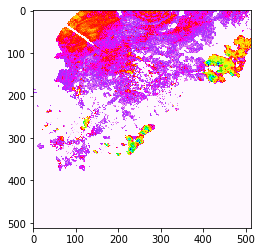

↓↓↓下面的是真实值，上面的是上一张↑↑↑


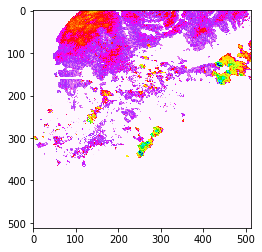

↓↓↓下面的是模型的输出，上面的是真实值↑↑↑


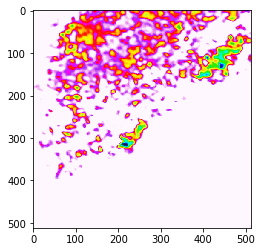

↓↓↓下面的是模型一整段的输出，上面的是最后一张输出↑↑↑


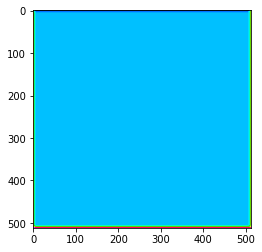

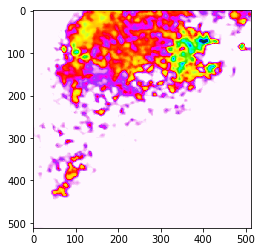

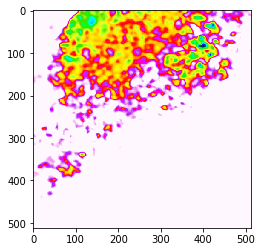

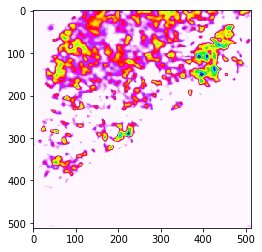

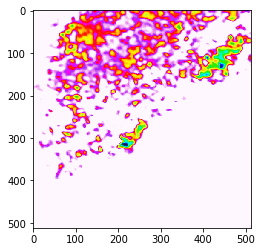

In [20]:
train_generator.on_epoch_end()
valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
y = test_model.predict(x)

plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型一整段的输出，上面的是最后一张输出↑↑↑')
for i in range(y.shape[1]):
    plt.imshow(y[0][i].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
    plt.show()

In [ ]:
y.shape[1]